In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller


In [2]:
# Read your dataset
data = pd.read_csv('/content/weather.csv')

# Convert Date to datetime
data['Date.Full'] = pd.to_datetime(data['Date.Full'])

# Group by Date and compute average for temperature and wind speed
df = data.groupby('Date.Full')[['Data.Temperature.Avg Temp', 'Data.Wind.Speed']].mean()

# Drop any missing values
df = df.dropna()

# Display first few rows
print(df.head())


            Data.Temperature.Avg Temp  Data.Wind.Speed
Date.Full                                             
2016-01-03                  34.841270         7.061492
2016-01-10                  35.139683         6.540159
2016-01-17                  33.800000         6.573746
2016-01-24                  32.266667         7.008984
2016-01-31                  40.790476         6.841746


In [3]:
# Apply ADF test to each column
for col in df.columns:
    result = adfuller(df[col])
    print(f'{col} ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')


Data.Temperature.Avg Temp ADF Statistic: -2.8710605184360745
p-value: 0.048818245821697505
Data.Wind.Speed ADF Statistic: -2.6728296080009297
p-value: 0.07885909237328653


In [4]:
df_diff = df.diff().dropna()

# Verify again
for col in df_diff.columns:
    result = adfuller(df_diff[col])
    print(f'{col} ADF Statistic after differencing: {result[0]}')
    print(f'p-value: {result[1]}')


Data.Temperature.Avg Temp ADF Statistic after differencing: -1.4051816730164128
p-value: 0.5797894536591474
Data.Wind.Speed ADF Statistic after differencing: -8.761840901860639
p-value: 2.6611605942702708e-14


In [5]:
train_size = int(len(df_diff) * 0.8)
train = df_diff[:train_size]
test = df_diff[train_size:]


In [7]:
# Automatically select maxlags with safe upper limit
model = VAR(train)
model_fitted = model.fit(ic='aic')  # let it decide the optimal lags
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Apr, 2025
Time:                     06:43:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.06671
Nobs:                     31.0000    HQIC:                  0.757196
Log likelihood:          -47.8944    FPE:                    2.03709
AIC:                     0.123884    Det(Omega_mle):        0.723982
--------------------------------------------------------------------
Results for equation Data.Temperature.Avg Temp
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                -0.286639         1.054665           -0.272           0.786
L1.Data.Temperature.Avg Temp         -0.044873         0.458963          

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [8]:
# Calculate safe maximum lags
print("Max safe lags:", len(train) // (len(train.columns) + 1))


Max safe lags: 13


In [9]:
# Forecasting
forecast_steps = len(test)
forecast = model_fitted.forecast(train.values, steps=forecast_steps)

# Convert back to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Data.Temperature.Avg Temp', 'Data.Wind.Speed'])
print(forecast_df.head())


            Data.Temperature.Avg Temp  Data.Wind.Speed
Date.Full                                             
2016-10-23                  -1.825692        -1.481116
2016-10-30                  -0.004435         0.992822
2016-11-06                  -2.012172         0.657501
2016-11-13                  -1.837824        -0.675269
2016-11-20                  -1.769297         0.757430


In [10]:
# Reverse differencing
last_train_values = df.iloc[train_size - 1]
forecast_actual = forecast_df.cumsum() + last_train_values

print(forecast_actual.head())


            Data.Temperature.Avg Temp  Data.Wind.Speed
Date.Full                                             
2016-10-23                  59.117526         4.970367
2016-10-30                  59.113091         5.963189
2016-11-06                  57.100919         6.620689
2016-11-13                  55.263095         5.945420
2016-11-20                  53.493798         6.702850


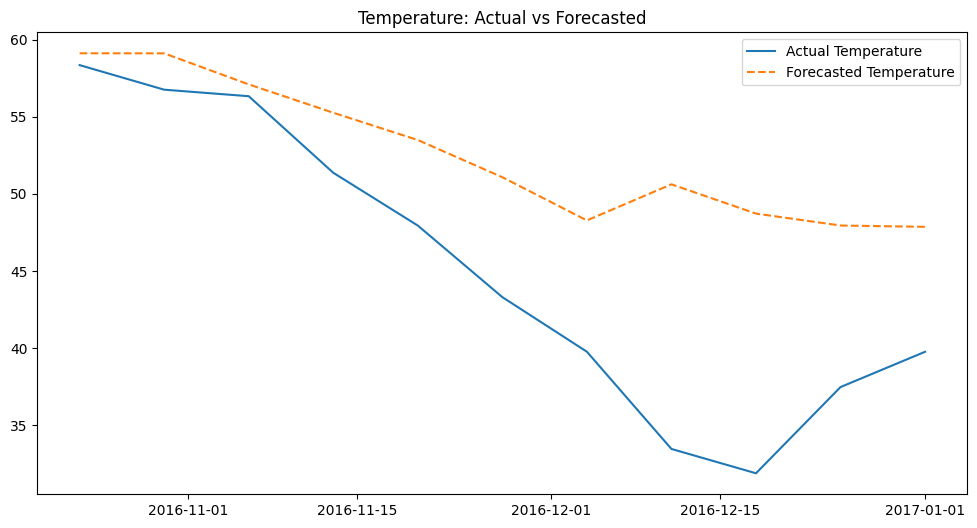

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-forecast_steps:], df['Data.Temperature.Avg Temp'][-forecast_steps:], label='Actual Temperature')
plt.plot(forecast_actual.index, forecast_actual['Data.Temperature.Avg Temp'], label='Forecasted Temperature', linestyle='dashed')
plt.legend()
plt.title("Temperature: Actual vs Forecasted")
plt.show()


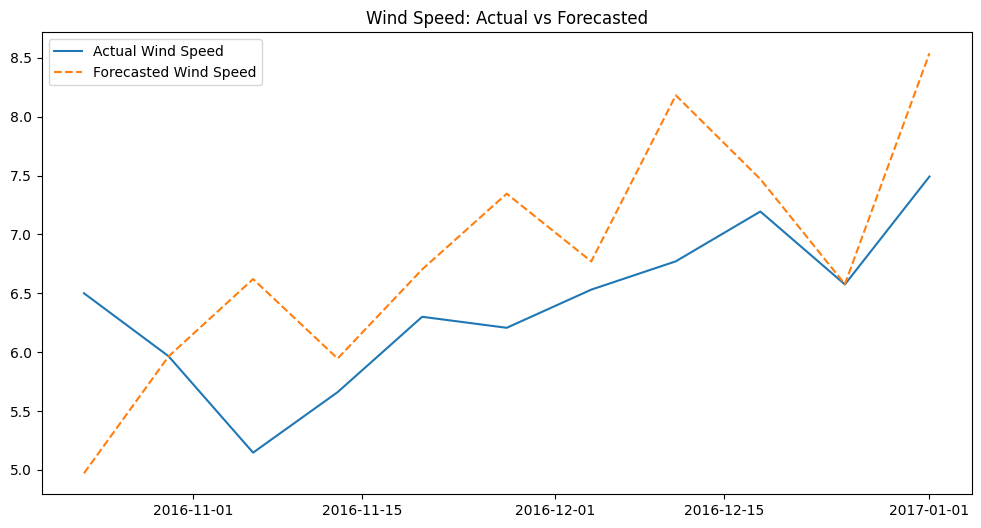

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-forecast_steps:], df['Data.Wind.Speed'][-forecast_steps:], label='Actual Wind Speed')
plt.plot(forecast_actual.index, forecast_actual['Data.Wind.Speed'], label='Forecasted Wind Speed', linestyle='dashed')
plt.legend()
plt.title("Wind Speed: Actual vs Forecasted")
plt.show()
